# Analyzing Spatial Patterns

---------------------------

In this practice session, you will learn how to apply basic **spatial analysis** techniques to inspect socioeconomic and environmental patterns in the Netherlands. The major technical step, *Inspecting Spatial Autocorrelation with the Moran's I Index*, will walk you step-by-step through the application of the Moran's I in detecting interesting clustered patterns in your spatial dataset, especially about that referred as the *hotspot* analysis. The data you will be working on is from the Dutch statistical bureau (Centraal Bureau voor de Statistiek, CBS), where you can be able to download socioeconomic information about the entire Netherlands with geospatial information attached. All the information is at different geographic levels, for instance, neighborhood, district and city level. Here in this session, we start with the city (gemeente) level for quick demonstration, but please feel free to download more detailed data from CBS.nl. We specifically look at the housing property value (WOZ) as an important indicator of social wellbeing and weathiness at the city level, and try to see how it manifested in space. Again, you are free to use other information contained in the same dataset, and please also refer to the mete data (PDF) for the meaning of the abbreviated data code.

For this session, we especially rely on the *libpysal* module, which is a very powerful *Python* tool for **spatial analysis**. It is also the backends of a few famous open source software, such as the [*Geoda*](https://geodacenter.github.io/workbook/5a_global_auto/lab5a.html#morans-i).

The content is adapted from: [The official open source PySAL online examples](https://pysal.org/notebooks/viz/splot/esda_morans_viz.html)

## Inspecting Spatial Autocorrelation with the Moran's I Index

### 0. Import necessary modules

In [31]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import geopandas as gpd
import os
! pip install splot
import splot
from ipywidgets import IntSlider
from IPython.display import display
from libpysal.weights import Queen, Rook, KNN
from splot.libpysal import plot_spatial_weights
from libpysal.weights import W, full
from esda.moran import Moran
from splot.esda import moran_scatterplot, plot_moran, lisa_cluster, plot_local_autocorrelation


### 1. Load and visualize the data

In [106]:
# Download data by cloning the data on Github to our Colab workspace

!git clone https://github.com/jonwangio/test_spatial_analysis

Cloning into 'morans'...
fatal: repository 'https://github.com/jonwangio/Programming-Basics/tree/master/data/morans/' not found


In [5]:
# As you can see, it is a *.shp file with attributes

ned = gpd.read_file('test_spatial_analysis/gemeente_2021.gpkg')

In [6]:
# Overview of the first few rows of the data as a table

ned.head() 

,GM_CODE,GM_NAAM,H2O,OAD,STED,BEV_DICHTH,AANT_INW,AANT_MAN,AANT_VROUW,P_00_14_JR,...,AF_ZONBNK,AF_ATTRAC,AV10ATTRAC,AV20ATTRAC,AV50ATTRAC,JRSTATCODE,JAAR,Shape_Leng,Shape_Area,geometry
0,GM0014,Groningen,NEE,3312,1,1257,233273,116177,117096,12,...,2.6,3.5,1.9,4.6,20.3,2021GM0014,2021,98454.011519,1.979605e+08,"POLYGON ((245229.700 592570.870, 245250.710 59..."
1,GM0034,Almere,NEE,1616,2,1662,214715,106523,108192,18,...,1.8,4.0,3.4,5.6,44.8,2021GM0034,2021,77001.560698,1.392038e+08,"MULTIPOLYGON (((142993.687 482642.725, 142993...."
2,GM0037,Stadskanaal,NEE,836,4,270,31754,15659,16095,14,...,4.4,4.3,1.1,4.4,21.0,2021GM0037,2021,64057.948253,1.199441e+08,"POLYGON ((263763.866 566430.392, 263944.283 56..."
3,GM0047,Veendam,NEE,1007,3,361,27417,13700,13717,15,...,1.9,11.4,0.0,5.2,20.9,2021GM0047,2021,39605.318697,7.867884e+07,"POLYGON ((256504.591 572265.478, 256541.115 57..."
4,GM0050,Zeewolde,NEE,822,4,93,22879,11662,11217,17,...,2.4,12.5,0.0,1.3,37.5,2021GM0050,2021,98901.663241,2.525283e+08,"MULTIPOLYGON (((165429.846 478378.250, 165403...."


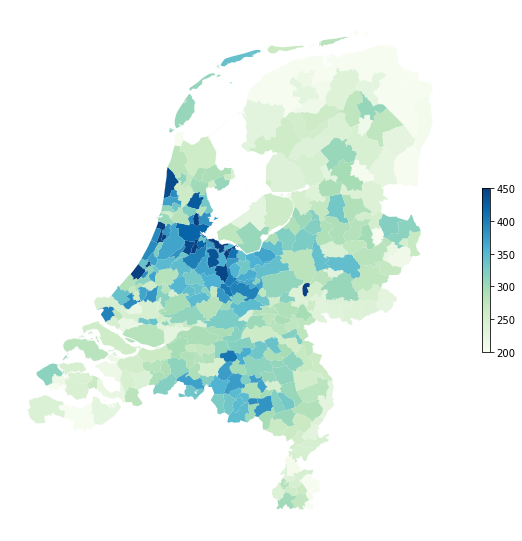

In [17]:
# Here, we look at the 'WOZ' data, it is a Dutch abbreviation of housing property values
# The values are with unit of *1000 euro, hence, 357 means 357,000 euros

ned['WOZ'].where(ned['WOZ']>0, 300, inplace=True)  # arbitrarily replace invalid values with a specified 300, do you have better ideas?

# Visualize the WOZ as a map
ax = ned.plot(ned['WOZ'], categorical=False, 
              legend=True, figsize=(10, 10), 
              cmap='GnBu', vmax=450, vmin=200, 
              legend_kwds={'shrink': 0.3})
ax.set_axis_off()

### 2. Spatial weights for spatial contiguity
-------------------
One important step for compute the Moran's I index for this area is to define the weights of the neighboring units for each spatial unit. The weights are normally defined according to the spatial contiguity between the spatial unit and its neighbors. In this case, each spatial unit is a city (gemeente), and its neighbors are simply those cities directly adjacent to it. Without knowing which of the neighbors are more related, the simplest way is to assign equal weights to all the adjcent neighbors. Normally, it is flexible to define spatial units further apart with a decreasing weights along distance, but how weights are decaying according to distance needs further modelling, as we already mentioned by using the variogram in Kriging.

In [95]:
# There is a function from libpysal that can help us assign equal weights to adjacent neighbors
# With the function that find K nearest neighbors (KNN), you will have a chance to define the number of neighbors K

k = IntSlider(min=2, max=10, step=1, value=2)
display(k)

IntSlider(value=2, max=10, min=2)

C:\Users\WangJ2\AppData\Local\Continuum\anaconda3\envs\geo\lib\site-packages\libpysal\weights\weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  warnings.warn(message)


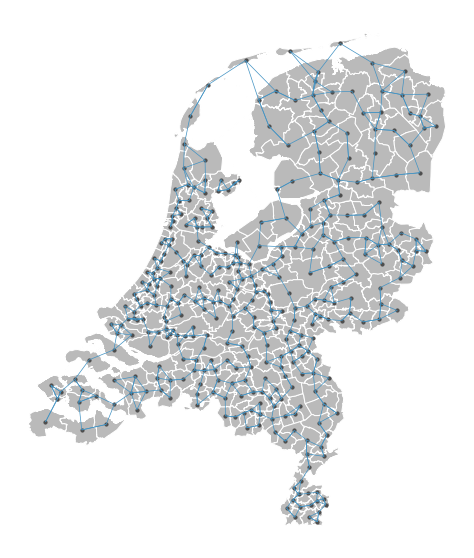

In [101]:
# Extract the target values from the source data in the table above
y = ned['WOZ'].values
w = KNN.from_dataframe(ned, k=k.value)

'''
w = Queen.from_dataframe(ned)
'''

w.transform = 'r'

# Visualize how the spatial contiguity are structured
plot_spatial_weights(w, ned)
plt.show()

In [102]:
# What does this mean?

w.weights[5]

[0.5, 0.5]

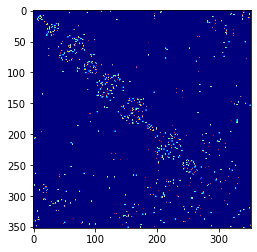

In [103]:
# We can also visualize the weights for all the elements as a matrix, and plot the matrix as a graph

wf, ids = full(w)
plt.imshow(wf, cmap='jet', vmax=0.2)

### 3. The Moran's I index
----------------------
Both the global and local Moran's I will be computed. Specifically, the local Moran's I can further be related to the *hotspot* analysis as showing particular association between low and high values in your study area.

In [104]:
# Once the weights and data values are ready, the Moran's I can be obtained easily with matrix product
# But here, we still rely on a existing tool to help us, which is the 'esda' module and has good online documentation

moran = Moran(y, w)
moran.I

0.5390742802844349

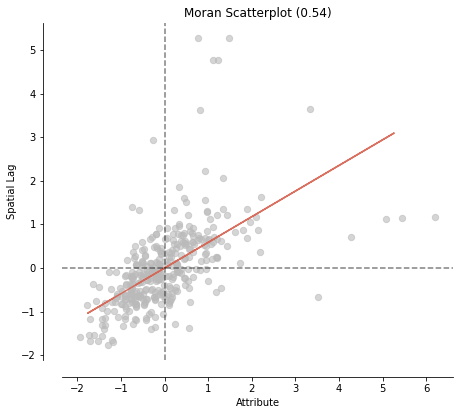

In [105]:
# As mentioned in the class, the Moran's I can be viewed as the correlation between the value of the target spatial unit and 
# those of its neighbors, hence, we can of course visualize it in such a way.

# Plot target value against its weighted neighbors
fig, ax = moran_scatterplot(moran, aspect_equal=True)
plt.show()